# CS 135 day 04: Hyperparameter Selection on Val. Set

We will explore *hyperparameter selection* using the new model family we just learned about, Linear Regression with Polynomial Features

# Objectives

* Learn how to compute polynomial features
* Try out selecting the polynomial degree on a fixed validation set

* Learn how to use sklearn's built-in Polynomial feature transformer
* Learn how to use sklearn pipelines to compose useful elementary transformations and predictors


# Outline

* Part 0: Linear Regression on Sine Wave dataset
* Part 1: Linear Regression on Sine Wave dataset
* Part 2: Trying Polynomial Features + Linear Regression by hand
* Part 3: Selecting degree on Fixed Validation Set
* Part 4: Polynomial Feature transformer
* Part 5: Pipelines


# Takeaways

* Hyperparameter selection is important to avoid overfitting (and underfitting)
* We cannot use the training set alone to select hyperparameters
* We should use a separate validation set to compute the error we use to select hyperparameters (or do cross-validation)
* Sklearn has many built-in features (Pipelines, feature transformers, etc) that make your life easier if you know how to use them well
* * They all follow a standard interface (aka "API")

In [1]:
import numpy as np
import pandas as pd

In [2]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

In [3]:
import sklearn.linear_model
import sklearn.pipeline

# Visualizing Polynomial features

In [4]:
# Set scale
min_x = -30
max_x = 31
N = (max_x - min_x)*2 +1

# Make a set of polynomial features
x_N4 = np.zeros((N,4))
x_N4[:,0] = np.linspace(min_x, max_x, N) #1,2,3...N-1,N
x_N4[:,1] = np.power(x_N4[:,0],2)        #1,4,9,...(N-1)^2,N^2
x_N4[:,2] = np.power(x_N4[:,0],3) 
x_N4[:,3] = np.power(x_N4[:,0],4) 

In [5]:
feats_df = pd.DataFrame(data=x_N4, columns=[r"$x$",r"$x^2$",r"$x^3$",r"$x^4$"])
feats_df

,$x$,$x^2$,$x^3$,$x^4$
0,-30.0,900.00,-27000.000,810000.0000
1,-29.5,870.25,-25672.375,757335.0625
2,-29.0,841.00,-24389.000,707281.0000
3,-28.5,812.25,-23149.125,659750.0625
4,-28.0,784.00,-21952.000,614656.0000
...,...,...,...,...
118,29.0,841.00,24389.000,707281.0000
119,29.5,870.25,25672.375,757335.0625
120,30.0,900.00,27000.000,810000.0000
121,30.5,930.25,28372.625,865365.0625


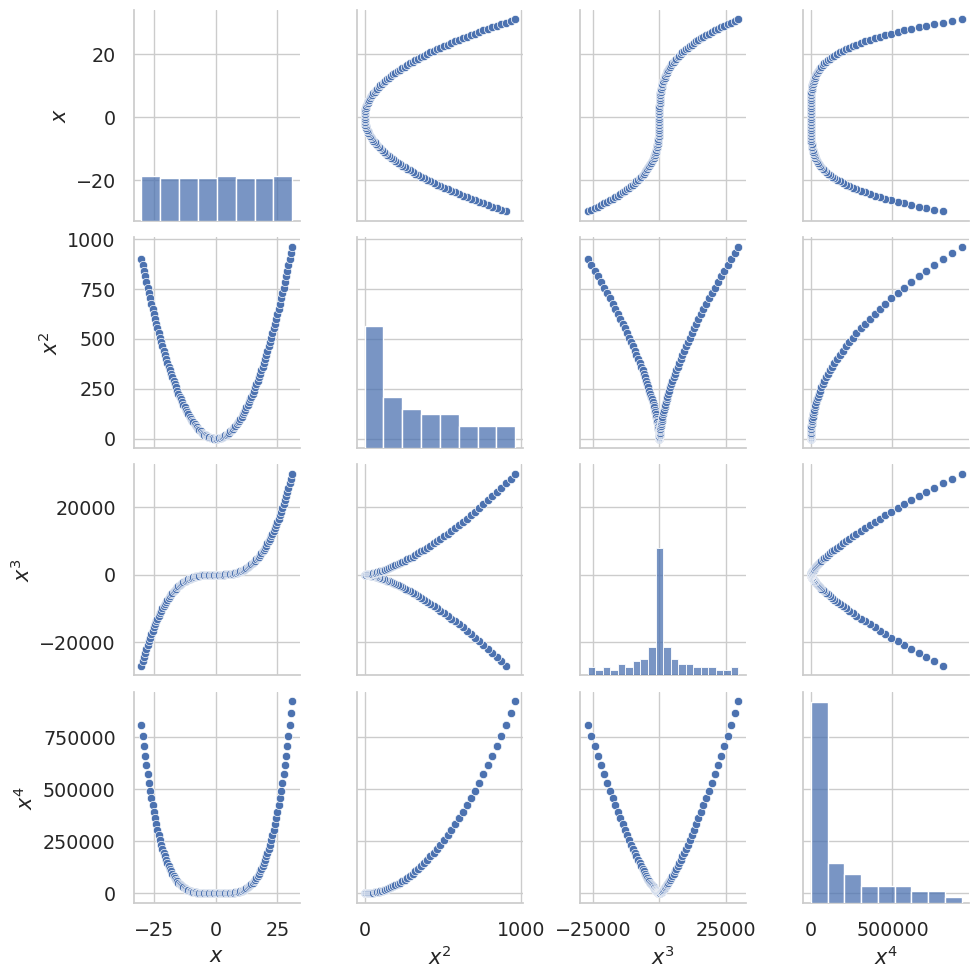

In [6]:
sns.pairplot(feats_df)

Let's make linear model that's the function
$$y = 4x^4 - x^3 + 2x^2 + \frac{x}{2}$$

In [7]:
w = np.array([-0.25, -6, 2, 0.5])
w_41 = np.reshape(w, (4,1))

Now let's look at this model's predictions in terms of x

In [8]:
y_N1 = x_N4.dot(w_41)
feats_df["y"] = y_N1
feats_df

,$x$,$x^2$,$x^3$,$x^4$,y
0,-30.0,900.00,-27000.000,810000.0000,345607.50000
1,-29.5,870.25,-25672.375,757335.0625,322108.65625
2,-29.0,841.00,-24389.000,707281.0000,299823.75000
3,-28.5,812.25,-23149.125,659750.0625,278710.40625
4,-28.0,784.00,-21952.000,614656.0000,258727.00000
...,...,...,...,...,...
118,29.0,841.00,24389.000,707281.0000,397365.25000
119,29.5,870.25,25672.375,757335.0625,424783.40625
120,30.0,900.00,27000.000,810000.0000,453592.50000
121,30.5,930.25,28372.625,865365.0625,483838.65625


<Axes: xlabel='$x$', ylabel='y'>

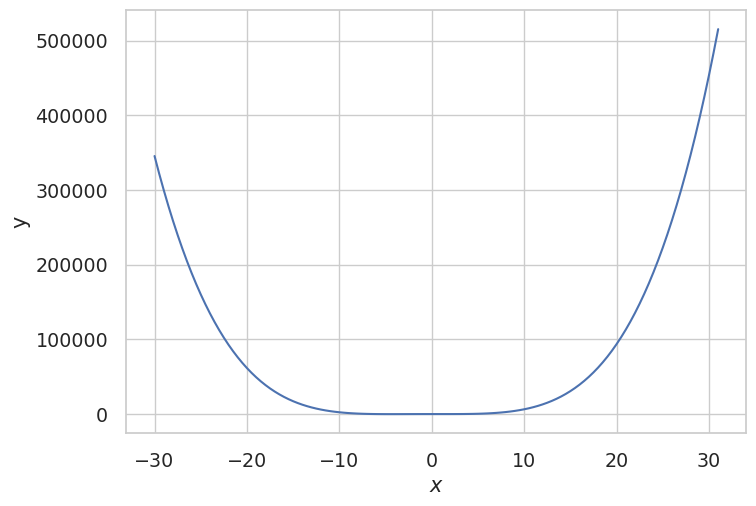

In [9]:
sns.lineplot(feats_df, x=r"$x$", y="y")

This shows our model as the typical function we're familiar with, and it certaintly looks non-linear. However, we can also interpret each x degree as a different feature. 

In [10]:
feats_df_long = pd.melt(feats_df, id_vars="y", value_vars=[r"$x$",r"$x^2$",r"$x^3$",r"$x^4$"],var_name="Feature")

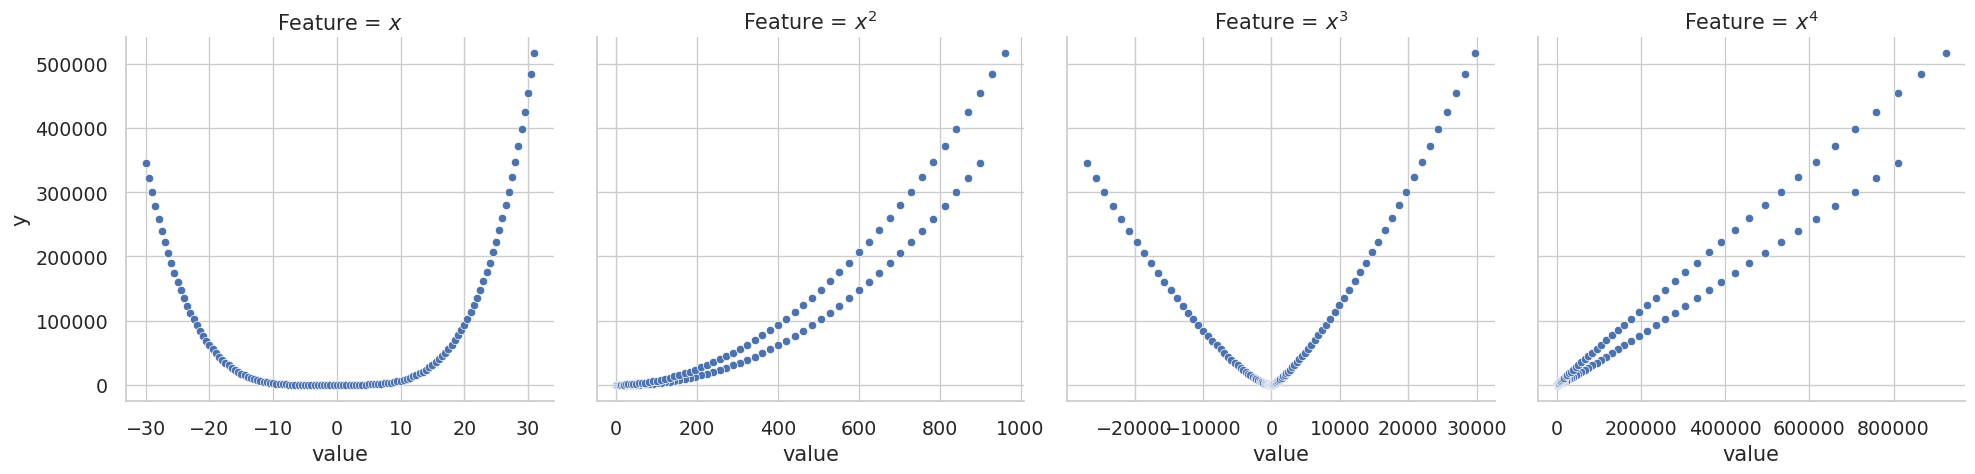

In [11]:
sns.relplot(feats_df_long, x="value", y="y",col="Feature", facet_kws={"sharex":False})

# Prepare a simple 'sine-wave' dataset

In [12]:
SEED = 12345
prng = np.random.RandomState(SEED)

In [13]:
def true_prediction_function(x):
    return np.sin(2.1 * x)

In [14]:
L = 9        # num training examples (to estimate weight parameters)

x_tr_L = np.linspace(-3, 3, L) + 0.09 * prng.randn(L)
y_tr_L = true_prediction_function(x_tr_L) + 0.06 * prng.randn(L)

In [15]:
N = 15      # num validation examples (to select hyperparameters)

x_va_N = np.linspace(-3.1, 3.1, N)
y_va_N = true_prediction_function(x_va_N) + 0.06 * prng.randn(N)

In [16]:
M = 500      # num testing examples (to show "true" generalization)

x_te_M = np.linspace(-3.5, 3.5, M)
y_te_M = true_prediction_function(x_te_M) + 0.06 * prng.randn(M)

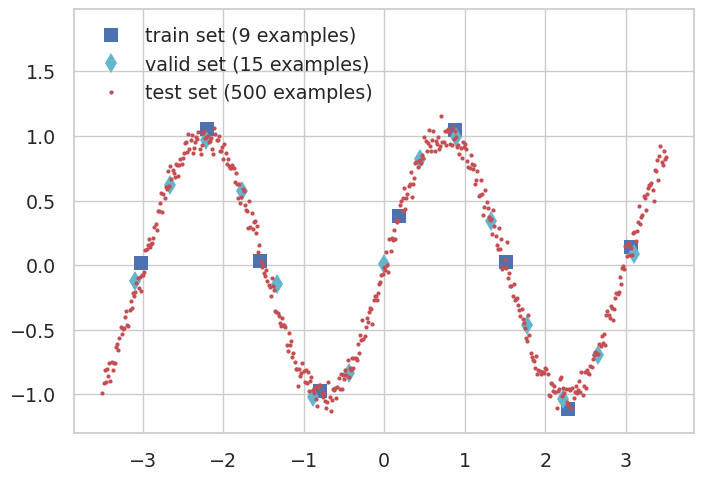

In [17]:
plt.plot(x_tr_L, y_tr_L, 'bs', markersize=10, label='train set (%d examples)' % L)
plt.plot(x_va_N, y_va_N, 'cd', markersize=10, label='valid set (%d examples)' % N)
plt.plot(x_te_M, y_te_M, 'r.', label='test set (%d examples)' % M)

plt.legend(loc='upper left');
plt.ylim([-1.3, 1.98]);

In [18]:
# Reshape all 'x' arrays so they are 2D with shape (n_examples, 1)

x_tr_L1 = x_tr_L[:,np.newaxis]
x_va_N1 = x_va_N[:,np.newaxis]
x_te_M1 = x_te_M[:,np.newaxis]

<a id="part1"></a>

# Part 1: Linear Regression

First, let's try to fit plain old linear regression to this dataset.

In [19]:
lin_regr = sklearn.linear_model.LinearRegression()

In [20]:
# Call 'fit', should update the object in place with fitted coefs
lin_regr.fit(x_tr_L1, y_tr_L)

LinearRegression()

What is the learned slope?

In [21]:
lin_regr.coef_

array([-0.07988729])

What is the learned intercept/bias value?

In [22]:
lin_regr.intercept_

0.06946611475632833

### Exercise 1a: Can you make predictions using the model above on the heldout test set?

In [23]:
yhat_te_M = np.ones(M) # TODO something like "lin_regr.predict(...)"

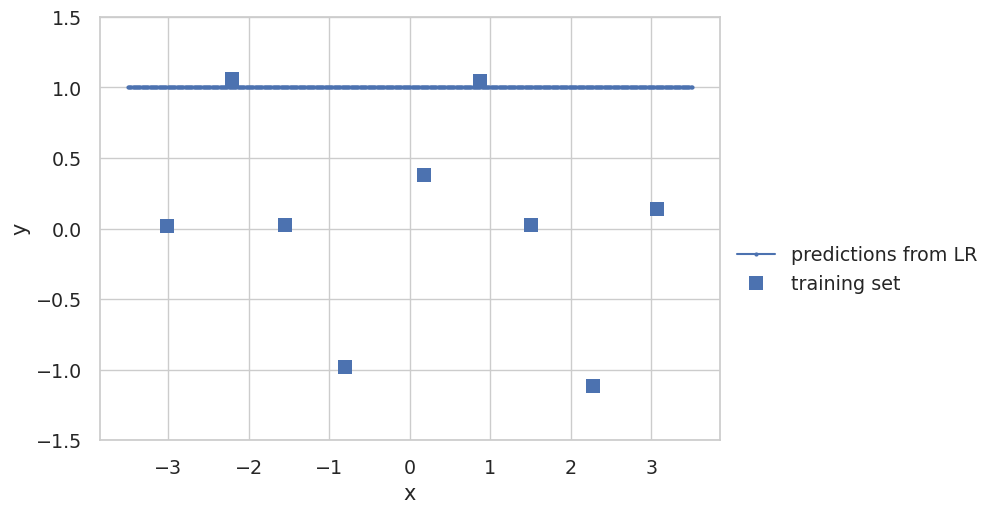

In [24]:
plt.plot(x_te_M, yhat_te_M, 'b.-', label='predictions from LR')
plt.plot(x_tr_L, y_tr_L, 'bs', markersize=10, label='training set')

plt.legend(bbox_to_anchor=(1.0, 0.5))
plt.ylim([-1.5, 1.5]);
plt.xlabel('x');
plt.ylabel('y');

# Part 2: Polynomial Features

Given our scalar feature $x_i \in \mathbb{R}$, we want to TRANSFORM it to a $F$-degree polynomial feature vector (of size $F+1$)

$$
\begin{align}
\phi_0(x_i) &= [1]
\\
\phi_1(x_i) &= [1 ~~ x_i]
\\
\phi_2(x_i) &= [1 ~~ x_i ~~ x_i^2]
\\
\phi_3(x_i) &= [1 ~~ x_i ~~ x_i^2 ~~ x_i^3] \\
\vdots \\
\phi_F(x_i) &= [1 ~~ x_i ~~ x_i^2 ~~ x_i^3 ~~ \ldots x_i^F]
\end{align}
$$

And then use these transformed features to do linear regression.

That is, we'll learn weights for each of the entries of the vector produced by $\phi_F$

### Polynomial feature expansion, in code

In [25]:
def make_poly_features(x_N1, degree=0):
    ''' Transform some 1-dim feature array into polynomial features
    
    Args
    ----
    x_N1 : 2D array, shape (N, 1)
        Input features of a 1d regression problem
    degree : int
        Indicates degree of polynomial
    
    Returns
    -------
    phi_NG : 2D array, shape (N, G)
        where G = degree + 1
    '''
    assert x_N1.ndim == 2
    N, _ = x_N1.shape
    
    phi_N1_list = list()
    deg0_N1 = np.ones((N, 1))
    phi_N1_list.append(deg0_N1)
    for d in range(1, degree+1):
        deg_d_feat_N1 = x_N1 ** d   # '**' means "to the power of"
        phi_N1_list.append(deg_d_feat_N1)

    # stack together horizontally all elts of phi_N1_list
    phi_NG = np.hstack(phi_N1_list)
    return phi_NG

Create an array to try things out as input

In [26]:
my_x_N1 = np.asarray([[0.], [1], [2], [3]])
print(my_x_N1)

[[0.]
 [1.]
 [2.]
 [3.]]


In [27]:
make_poly_features(my_x_N1, degree = 0)

array([[1.],
       [1.],
       [1.],
       [1.]])

In [28]:
make_poly_features(my_x_N1, degree = 1)

array([[1., 0.],
       [1., 1.],
       [1., 2.],
       [1., 3.]])

In [29]:
make_poly_features(my_x_N1, degree = 2)

array([[1., 0., 0.],
       [1., 1., 1.],
       [1., 2., 4.],
       [1., 3., 9.]])

## Exercise 2b

What happens to my_x_N1 if you ask for a polynomial with degree 4?

In [30]:
# TODO

# Part 3: Hyperparameter Selection for Poly Regr.




### Exercise 3a: Edit code below to properly do the polynomial feature transformation 

Hint: in lines marked TODO, call the `make_poly_features' function defined above

degree 1 | tr err      0.485 | va err      0.426 | test err      0.482
degree 2 | tr err      0.485 | va err      0.426 | test err      0.482
degree 3 | tr err      0.485 | va err      0.426 | test err      0.482
degree 4 | tr err      0.485 | va err      0.426 | test err      0.482
degree 5 | tr err      0.485 | va err      0.426 | test err      0.482
degree 6 | tr err      0.485 | va err      0.426 | test err      0.482
degree 7 | tr err      0.485 | va err      0.426 | test err      0.482
degree 8 | tr err      0.485 | va err      0.426 | test err      0.482


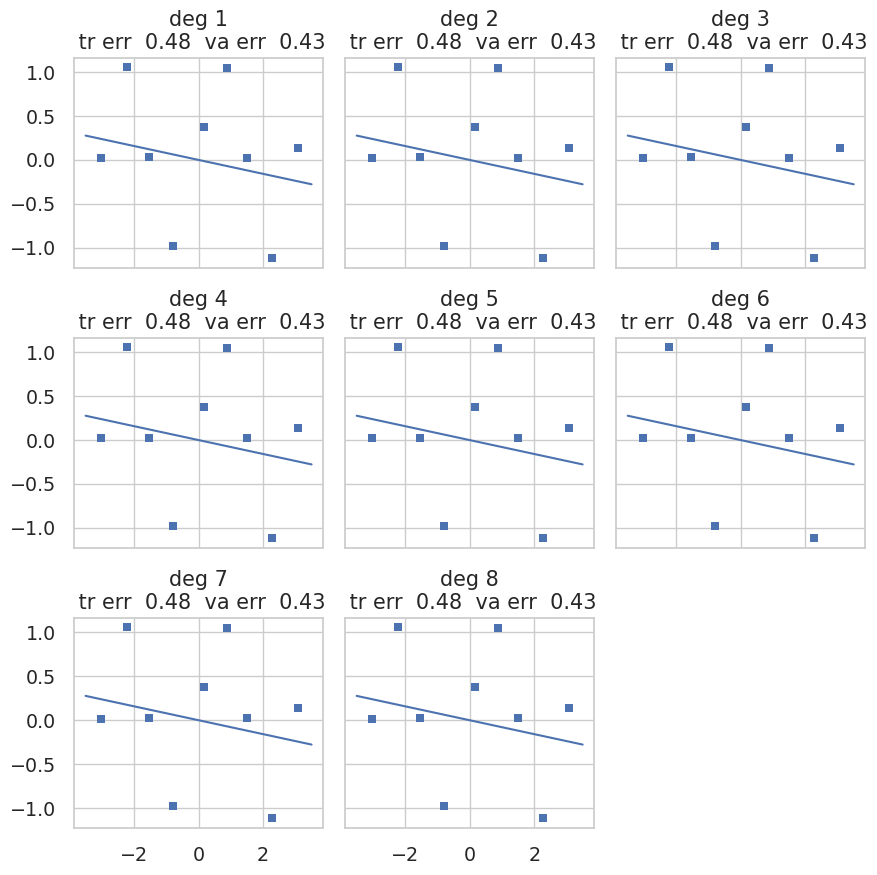

In [31]:
fig_h, ax_33 = plt.subplots(
    nrows=3, ncols=3, sharex=True, sharey=True,
    figsize=(9,9))
ax_9 = ax_33.reshape((9,))
ax_9[-1].set_visible(False)

for ii, degree in enumerate([1, 2, 3, 4, 5, 6, 7, 8]):
    cur_ax = ax_9[ii]

    # Please Carefully Think through why we set "fit_intercept=False" here:
    # This is not because we don't want bias (i.e. set it to zero).
    # Instead, the bias(intercept) to be fitted is included as degree 0 of the polynomial.
    lin_regr = sklearn.linear_model.LinearRegression(fit_intercept=False)
    
    phi_tr_LG = x_tr_L1 # TODO fix to transform x with your function "make_poly_features" above!
    phi_va_NG = x_va_N1 # TODO fix to transform validation features
    phi_te_MG = x_te_M1 # TODO fix to transform test features

    # Train the model
    lin_regr.fit(phi_tr_LG, y_tr_L)

    # Make predictions
    yhat_tr_L = lin_regr.predict(phi_tr_LG)
    yhat_va_N = lin_regr.predict(phi_va_NG)
    yhat_te_M = lin_regr.predict(phi_te_MG)
    
    # Evaluate the ERROR on training set and test set
    tr_err = sklearn.metrics.mean_squared_error(y_tr_L, yhat_tr_L)
    va_err = sklearn.metrics.mean_squared_error(y_va_N, yhat_va_N)
    te_err = sklearn.metrics.mean_squared_error(y_te_M, yhat_te_M)
    
    print("degree %d | tr err %10.3f | va err %10.3f | test err %10.3f" % (
        degree, tr_err, va_err, te_err))
    
    # Plot the predictions on current axis
    cur_ax.plot(x_te_M1, yhat_te_M, 'b-');
    cur_ax.plot(x_tr_L, y_tr_L, 'bs');
    
    cur_ax.set_title('deg %d\n tr err % .2f  va err % .2f' % 
                     (degree, tr_err, va_err))
plt.tight_layout(); # make look pretty

### Exercise 3b: Which degree offers the lowest error on the validation dataset?

In [32]:
# TODO fill

### Exercise 3c: Which degree offers the lowest error on the test dataset?

WARNING: if you really used this to pick your degree you could not later use the test set to fairly report your model's ability to generalize. Once you use the test set to train or select, you can't reuse it.

In [33]:
# TODO fill

# Part 4: Using sklearn's built in Polynomial feature transform

You might want to read up here:

<https://scikit-learn.org/stable/modules/preprocessing.html#generating-polynomial-features>

Now let's dive in! 

In [34]:
from sklearn.preprocessing import PolynomialFeatures

my_x_N1 = np.arange(3).reshape(3, 1)
print("Original Features my_x_N1")
print(my_x_N1)

Original Features my_x_N1
[[0]
 [1]
 [2]]


In [35]:
poly = PolynomialFeatures(2)
# call 'fit_transform' to perform the transformation
phi_NG = poly.fit_transform(my_x_N1) 

print("Transformed Features phi_NG using 2-degree polynomial")
print(phi_NG)

Transformed Features phi_NG using 2-degree polynomial
[[1. 0. 0.]
 [1. 1. 1.]
 [1. 2. 4.]]


In [36]:
poly = PolynomialFeatures(5)
phi_NG = poly.fit_transform(my_x_N1)

print("Transformed Features phi_NG using 5-degree polynomial")
print(phi_NG)

Transformed Features phi_NG using 5-degree polynomial
[[ 1.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.]
 [ 1.  2.  4.  8. 16. 32.]]


Now try with more than one feature (e.g. each x vector is 2-dim.)

In [37]:
my_x_N2 = np.asarray([[0, 3], [1, 4], [2, 5]])
print("Original Features my_x_N2")
print(my_x_N2)

Original Features my_x_N2
[[0 3]
 [1 4]
 [2 5]]


In [38]:
poly = PolynomialFeatures(1)
phi_NG = poly.fit_transform(my_x_N2)

print("Transformed Features phi_NG using 1-degree polynomial")
print(phi_NG)

Transformed Features phi_NG using 1-degree polynomial
[[1. 0. 3.]
 [1. 1. 4.]
 [1. 2. 5.]]


In [39]:
poly = PolynomialFeatures(2)
phi_NG = poly.fit_transform(my_x_N2)

print("Transformed Features phi_NG using 2-degree polynomial")
print(phi_NG)

Transformed Features phi_NG using 2-degree polynomial
[[ 1.  0.  3.  0.  0.  9.]
 [ 1.  1.  4.  1.  4. 16.]
 [ 1.  2.  5.  4. 10. 25.]]


Conveniently, we can ask the feature transformer how it came up with these features

In [40]:
input_feat_names = ['a', 'b']
poly.get_feature_names_out(input_feat_names)

array(['1', 'a', 'b', 'a^2', 'a b', 'b^2'], dtype=object)

Now try 3-rd degree

In [41]:
poly = PolynomialFeatures(3)
phi_NG = poly.fit_transform(my_x_N2)

print("Transformed Features phi_NG using 3-degree polynomial")
print(phi_NG)

Transformed Features phi_NG using 3-degree polynomial
[[  1.   0.   3.   0.   0.   9.   0.   0.   0.  27.]
 [  1.   1.   4.   1.   4.  16.   1.   4.  16.  64.]
 [  1.   2.   5.   4.  10.  25.   8.  20.  50. 125.]]


In [42]:
poly.get_feature_names_out(input_feat_names)

array(['1', 'a', 'b', 'a^2', 'a b', 'b^2', 'a^3', 'a^2 b', 'a b^2', 'b^3'],
      dtype=object)

# Part 5: Using sklearn's built in Pipeline system

Often, we want to compose together some feature transformations and some predictor (like Linear Regression)

Sklearn lets us do that easily with a Pipeline

Read up here: 

<https://scikit-learn.org/stable/modules/compose.html#pipeline>

The key advantages of pipelines here are 

**Convenience** 

A pipeline is one object that handles everything

* every time we call fit, we first transform the raw features "x" into the transformed ones "phi", and then we do linear regression fitting using those transformed features
* every time we call predict, we first transform the raw features "x" into the transformed ones "phi", and then use linear regression to predict

Otherwise, we'd have to call `make_poly_features' so many times.

**Correctness**

Pipelines help us avoid having data leaks (e.g. have test data impact the transformation we learn). More about this later in the course.

To construct a pipeline, we just provide a list of steps.

Each STEP is just a tuple:
* first entry is the string name of the step (can be anything you want)
* second entry is the constructed sklearn estimator that will implement that step

In [43]:
pipeline = sklearn.pipeline.Pipeline([
    ("step1", sklearn.preprocessing.PolynomialFeatures()),
    ("step2", sklearn.linear_model.LinearRegression()),
    ])

In [44]:
pipeline

Pipeline(steps=[('step1', PolynomialFeatures()), ('step2', LinearRegression())])

Now, we can use a pipeline like so:

degree   1 | tr err      0.480 | va err      0.430 | test err      0.487
degree   2 | tr err      0.479 | va err      0.430 | test err      0.488
degree   3 | tr err      0.478 | va err      0.428 | test err      0.496
degree   4 | tr err      0.472 | va err      0.436 | test err      0.511
degree   5 | tr err      0.026 | va err      0.127 | test err      0.844
degree   6 | tr err      0.025 | va err      0.135 | test err      0.894
degree   7 | tr err      0.000 | va err      0.011 | test err      0.432
degree   8 | tr err      0.000 | va err      0.013 | test err      0.472
degree   9 | tr err      0.000 | va err      3.168 | test err    194.858


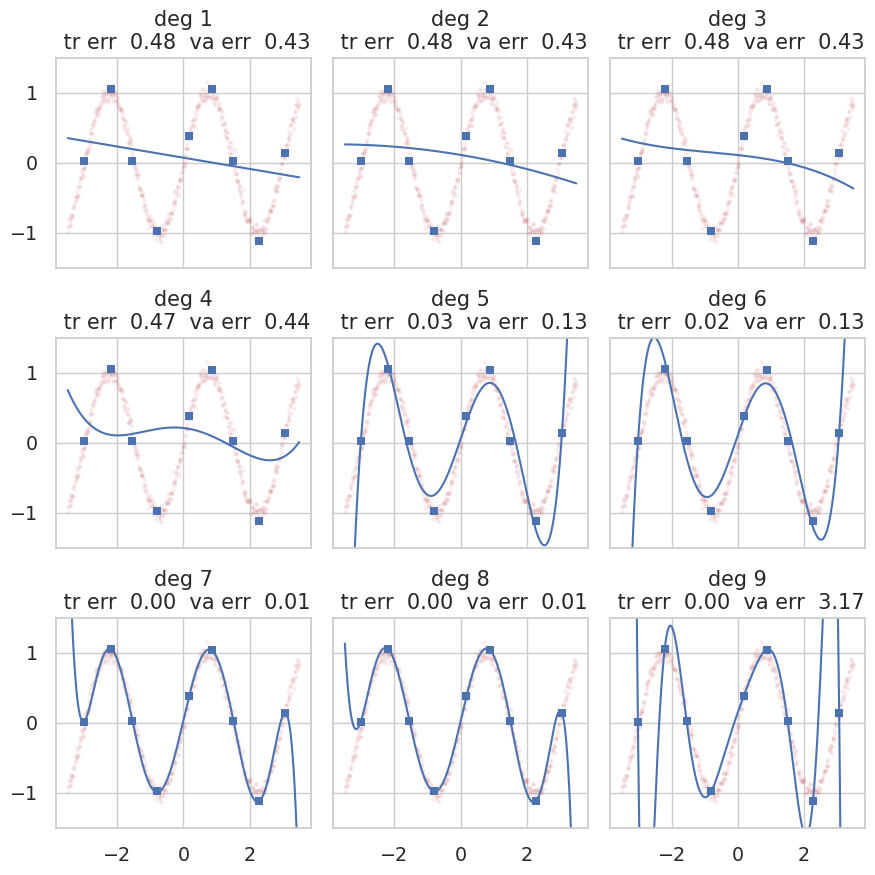

In [45]:
fig_h, ax_33 = plt.subplots(
    nrows=3, ncols=3, sharex=True, sharey=True, figsize=(9,9))
ax_9 = ax_33.reshape((9,))

for ii, degree in enumerate([1, 2, 3, 4, 5, 6, 7, 8, 9]):
    cur_ax = ax_9[ii]
    
    pipeline = sklearn.pipeline.Pipeline([
        ("step1", sklearn.preprocessing.PolynomialFeatures(degree)), # create custom Poly featurizer
        ("step2", sklearn.linear_model.LinearRegression()),
        ])

    # Train the model
    pipeline.fit(x_tr_L1, y_tr_L)         # Can use raw x here, unlike above

    # Make predictions
    yhat_tr_L = pipeline.predict(x_tr_L1) # Can use raw x here too!
    yhat_va_N = pipeline.predict(x_va_N1)
    yhat_te_M = pipeline.predict(x_te_M1)
    
    # Evaluate the ERROR on training set and test set
    tr_err = sklearn.metrics.mean_squared_error(y_tr_L, yhat_tr_L)
    va_err = sklearn.metrics.mean_squared_error(y_va_N, yhat_va_N)
    te_err = sklearn.metrics.mean_squared_error(y_te_M, yhat_te_M)
    
    print("degree %3d | tr err % 10.3f | va err %10.3f | test err % 10.3f" % (
        degree, tr_err, va_err, te_err))
    
    # Plot the predictions on current axis
    cur_ax.plot(x_te_M1, y_te_M, 'r.', alpha=0.1);
    cur_ax.plot(x_te_M1, yhat_te_M, 'b-');
    cur_ax.plot(x_tr_L, y_tr_L, 'bs');
    
    cur_ax.set_title('deg %d\n tr err % .2f  va err % .2f' % 
                     (degree, tr_err, va_err))
    cur_ax.set_ylim([-1.5, 1.5]);
plt.tight_layout(); # make look pretty

### Discussion 5a: Which degree would you select to minimize error on the validation set?

### Discussion 5b: For the selected model from 5a, what do you notice about the error INSIDE the bounds of observed training data versus OUTSIDE the bounds?